# Introduction

**Overview**

The given dataset from the website www.insideairbnb.com contains **information on 25,164 Airbnb listings from Berlin**. Each of those accommodations offers a different value proposition and a corresponding price. As a business graduate I have always been interested in investigating relationships like these. In this analysis I want to **explore the different value components of Airbnb properties** and **understand their impact on price**. 

In particular, I will focus on the following **seven value drivers**:

* Property Type
* Location
* Spaciousness
* Cleanliness
* Amenities
* Reservation Terms
* Host

I will examine the specification of these value drivers in the present dataset and their effects on price. Furthermore, I will investigate different **pricing strategies of the providers** themselves. This includes personal discounts, quantity discounts and the anticipation of additional costs such as cleaning fees or security deposits. By the very end of the analysis, I will evaluate the potential of the above mentioned value drivers to **predict accomondation prices using a simple linear regression model**.

**Business Questions**

Among others, I will give answers to the following questions in the course of this analysis:

1. In which neighbourhoods do hosts charge the highest prices?
2. Is there a relationship between the number of listings per neighbourhood an its average price?
3. What are common amenities that hosts provide?
4. Is there a relationship between the number of amenities provided and price?
5. Do the reservation terms of a listing impact its price?
6. Do hosts give personal or volume discounts?
7. What types of costs can users expect in addition to regular prices?

# Data Cleaning

Before we can dive into the analysis, it is necessary to bring the data into an appropriate format. Therefore, I will proceed in six steps:

1. Import the relevant packages
2. Read in the data
3. Clean boolean columns
4. Clean price columns
5. Clean percentage columns
6. Decode nested columns

**1. Import the relevant packages**

In [694]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from numpy.polynomial.polynomial import polyfit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import r2_score
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

**2. Read the listings data**

In [2]:
# Read the listings data
listings = pd.read_csv('./data/listings.csv.gz', compression='gzip', low_memory=False)
print(listings.shape)
listings.head()

(25164, 106)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3176,https://www.airbnb.com/rooms/3176,20200317045838,2020-03-17,Fabulous Flat in great Location,This beautiful first floor apartment is situa...,1st floor (68m2) apartment on Kollwitzplatz/ P...,This beautiful first floor apartment is situa...,none,The neighbourhood is famous for its variety of...,We welcome FAMILIES and cater especially for y...,"We are 5 min walk away from the tram M2, whic...",The apartment will be entirely yours. We are c...,Feel free to ask any questions prior to bookin...,"It’s a non smoking flat, which likes to be tre...",NaN,NaN,https://a0.muscache.com/im/pictures/243355/84a...,NaN,3718,https://www.airbnb.com/users/show/3718,Britta,2008-10-19,"Coledale, New South Wales, Australia",We love to travel ourselves a lot and prefer t...,within a few hours,100%,80%,f,https://a0.muscache.com/im/users/3718/profile_...,https://a0.muscache.com/im/users/3718/profile_...,Prenzlauer Berg,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'man...",t,t,"Berlin, Berlin, Germany",Prenzlauer Berg,Prenzlauer Berg Südwest,Pankow,Berlin,Berlin,10405,Berlin,"Berlin, Germany",DE,Germany,52.53500,13.41758,t,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",720.0,$90.00,$520.00,"$1,900.00",$300.00,$100.00,2,$20.00,62,1125,62,62,1125,1125,62.0,1125.0,3 weeks ago,t,0,0,0,140,2020-03-17,145,1,2009-06-20,2019-06-27,93.0,9.0,9.0,9.0,9.0,10.0,9.0,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,1,0,0,1.11
1,3309,https://www.airbnb.com/rooms/3309,20200317045838,2020-03-17,BerlinSpot Schöneberg near KaDeWe,First of all: I prefer short-notice bookings. ...,"Your room is really big and has 26 sqm, is ver...",First of all: I prefer short-notice bookings. ...,none,"My flat is in the middle of West-Berlin, direc...",The flat is a strictly non-smoking facility! A...,The public transportation is excellent: Severa...,I do have a strictly non-smoker-flat. Keep th...,I'm working as a freelancing photographer. My ...,House-Rules and Information ..............(deu...,NaN,NaN,https://a0.muscache.com/im/pictures/29054294/b...,NaN,4108,https://www.airbnb.com/users/show/4108,Jana,2008-11-07,"Berlin, Berlin, Germany",ENJOY EVERY DAY AS IF IT'S YOUR LAST!!! \r\n\r...,within a day,100%,100%,f,https:

**3. Clean all boolean columns**

In [3]:
listings.replace({'t': True, 'f': False}, inplace=True)

**4. Clean all columns that represent prices**

In [4]:
def clean_price_column(s):
    ''' Removes the '$' and ',' from all elements of a given 
    price column and returns the column as np.float64 type
    
    Input:
    s - pd.Series
    
    Output:
    pd.Series
    '''
    
    trans_dict = str.maketrans({'$': '', ',': ''})
    return s.str.translate(trans_dict).astype(np.float64)

price_cols = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']
listings[price_cols] = listings[price_cols].apply(clean_price_column, axis=0)

**5. Clean all columns that represent rates**

In [5]:
def clean_rate_column(s):
    ''' Removes the '%' from all elements of a given rate column,
    divides it by 100 and returns the column as np.float64 type
    
    Input:
    s - pd.Series
    
    Output:
    pd.Series
    '''
    
    return s.str.replace('%', '').astype(np.float64)/100

rate_cols = ['host_response_rate', 'host_acceptance_rate']
listings[rate_cols] = listings[rate_cols].apply(clean_rate_column, axis=0)

**6. Decode the amenities column and save in extra dataframe**

In [6]:
clean_string = lambda s: s.strip('{}').replace('"', '')
listings_amenities = listings.amenities.map(clean_string).str.get_dummies(sep=',')
listings_amenities.columns = listings_amenities.columns.str.strip()
listings_amenities.sort_index(axis=1, inplace=True)
listings.drop('amenities', axis=1, inplace=True)
listings_amenities.head()

,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,Air purifier,Amazon Echo,BBQ grill,Baby bath,Baby monitor,Babysitter recommendations,Baking sheet,Balcony,Barbecue utensils,Bath towel,Bathroom essentials,Bathtub,Bathtub with bath chair,Beach essentials,Beach view,Beachfront,Bed linens,Bedroom comforts,Bidet,Body soap,Bread maker,Breakfast,Breakfast table,Building staff,Buzzer/wireless intercom,Cable TV,Carbon monoxide detector,Cat(s),Ceiling fan,Changing table,Children’s books and toys,Children’s dinnerware,Cleaning before checkout,Coffee maker,Convection oven,Cooking basics,Crib,DVD player,Day bed,Disabled parking spot,Dishes and silverware,Dishwasher,Dog(s),Doorman,Double oven,Dryer,EV charger,Elevator,En suite bathroom,Espresso machine,Essentials,Ethernet connection,Extra pillows and blankets,Extra space around bed,Family/kid friendly,Fax machine,Fire extinguisher,Fire pit,Fireplace guards,Firm mattress,First aid kit,Fixed grab bars for shower,Fixed grab bars for toilet,Flat path to guest entrance,Formal dining area,Free parking on premises,Free street parking,Full kitchen,Game console,Garden or backyard,Gas oven,Ground floor access,Gym,HBO GO,Hair dryer,Hammock,Handheld shower head,Hangers,Heated floors,Heated towel rack,Heating,High chair,High-resolution computer monitor,Host greets you,Hot tub,Hot water,Hot water kettle,Indoor fireplace,Internet,Iron,Keypad,Kitchen,Kitchenette,Lake access,Laptop friendly workspace,Lock on bedroom door,Lockbox,Long term stays allowed,Luggage dropoff allowed,Memory foam mattress,Microwave,Mini fridge,Mudroom,Murphy bed,Netflix,No stairs or steps to enter,Other,Other pet(s),Outdoor parking,Outdoor seating,Outlet covers,Oven,Pack ’n Play/travel crib,Paid parking off premises,Paid parking on premises,Patio or balcony,Pets allowed,Pets live on this property,Pillow-top mattress,Pocket wifi,Pool,Printer,Private bathroom,Private entrance,Private hot tub,Private living room,Projector and screen,Rain shower,Refrigerator,Room-darkening shades,Safety card,Self check-in,Shampoo,Shower chair,Shower gel,Single level home,Ski-in/Ski-out,Smart TV,Smart lock,Smoke detector,Smoking allowed,Soaking tub,Sound system,Stair gates,Stand alone steam shower,Standing valet,Steam oven,Step-free shower,Stove,Suitable for events,Sun loungers,TV,Table corner guards,Terrace,Toilet paper,Trash can,Walk-in shower,Warming drawer,Washer,Washer/Dryer,Waterfront,Well-lit path to entrance,Wheelchair accessible,Wide clearance to shower,Wide doorway to guest bathroom,Wide entrance,Wide entrance for guests,Wide entryway,Wide hallways,Wifi,Window guards,Wine cooler,toilet,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,

# Data Exploration

With the data now in the right format, we can move into data exploration. First I will give a **general overview** of the dataset. Then I will dive deeper into the **seven value drivers** of the Airbnb listings and their **relation to price**. Finally, I will then explore in detail the **pricing strategies** of different providers, including discounts offered and additional costs charged.

## General Overview

**Number of observations and variables**

The dataset comprises **information on 25,164 Airbnb listings**. Each listing is described by **105 variables** and 179 potential additional amenities.

In [7]:
print(listings.shape)
print(listings_amenities.shape)

(25164, 105)
(25164, 179)


**Proportion of missing values**

52 of the 105 columns contain missing values. There are only a few variables with a critical missing value rate though, most of which are not relevant in this analysis anyway. However, I consider the high number of missing values in the columns `square_feet`, `weekly_price` and `monthly_price` to be critical. **I will omit the square feet variable** in the further analysis because of its marginal prevalence, and as I can not find an explanation for this observation. Regarding the price variables, I would expect that not all accommodations offer volume discounts and that this is the reason for at least some of the missing values. Therefore **I will still consider the price variables** in the further course of this analysis, but keep in mind the high rate of missing values. 

In [8]:
missings = listings.isna().mean()
print((missings>0).sum())

52


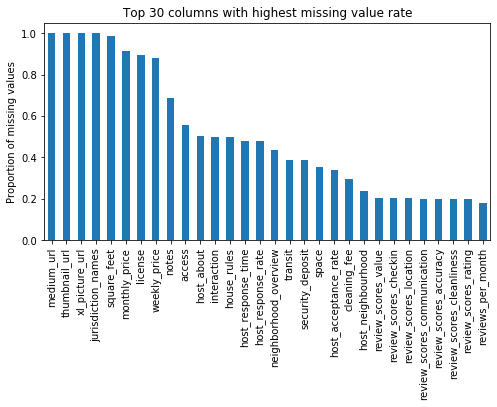

In [9]:
top_missings = missings.sort_values(ascending=False).iloc[:30]
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set_title('Top 30 columns with highest missing value rate')
ax.set_ylabel('Proportion of missing values')
top_missings.plot(kind='bar', ax=ax)
plt.show()

**Correlation between variables**

For me, there are **two interesting clusters** in the correlation heatmap. 

First, there seems to be a **high correlation between the spaciousness of an accommondation and its price**, including extra charges like security deposits or cleaning fees. This already gives us a first indication that it indeed makes sense to investigate the relationship between the spaciousness and the price of an accommodation in more detail. 

Second, there is a **high correlation between the various aspects of a guest rating** (accuracy, cleanliness, checkin, communication, location, value). Obviously, it is hard for users to give differentiated feedback resulting in spill over effects between different rating dimensions. This is a common pattern for multifacet reviews and I remember from my marketing masters that there has been already much literature on this issues.

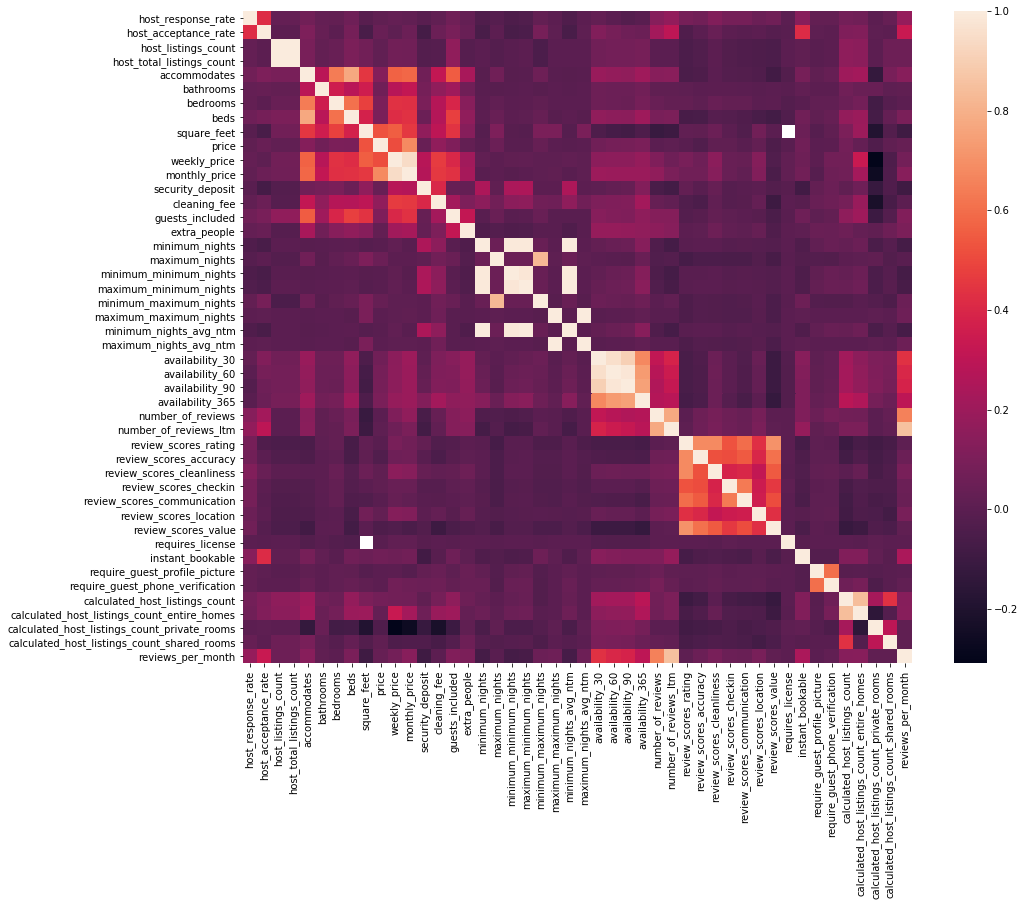

In [10]:
plt.figure(figsize=(15,12))
ignore_cols = ['id', 'scrape_id', 'thumbnail_url', 'medium_url', 'xl_picture_url', 'host_id', 
               'is_business_travel_ready', 'latitude', 'longitude', 'is_location_exact', 'has_availability', 
               'jurisdiction_names'] # variables where correlation is meaningless or variance is zero
sns.heatmap(listings.drop(ignore_cols, axis=1).corr(), annot=False)
plt.show()

## Property Types

In Berlin there exist **33 different Airbnb property types** with regular **apartments being with 88.6% by far the largest group**. Other common property types are condominiums (2.4%), lofts (2.0%), houses (1.8%), sercived apartments (1.4%) and hostels (0.9%). But the range also includes exceptional property types such as tiny houses, boats and castles.

The different property types are also **associated with different prices**. There are **some property types being far more expensive** than average like **hotels, boats and hostels**. Most of the remaining property types have prices that are rather close to the overall average.

In the following I will subset the dataset to regular apartments for a better comparison of different offers. For me this seems to be reasonable since apartments cover most of the listings anyway.

In [11]:
print(listings.property_type.unique().shape[0])

33


In [33]:
print((listings.property_type.value_counts()/listings.shape[0]).iloc[:6])

Apartment             0.886385
Condominium           0.024718
Loft                  0.020148
House                 0.018836
Serviced apartment    0.013511
Hostel                0.008703
Name: property_type, dtype: float64


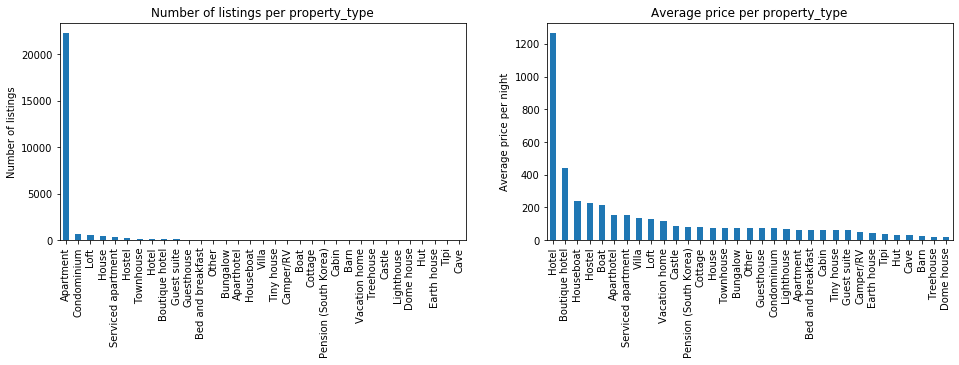

In [301]:
def plot_count_and_average_price_of_groups(df, group_var, price_var, sort_left='value', sort_right='value'):
    ''' Returns a figure with two plots in one row
    Plot 1 shows the count for each group of the column group_var of the dataframe df
    Plot 2 shows the average price for each group of the column group_var of the dataframe df 
    
    Input
    df - pd.DataFrame, containing the variables group_var and price_var
    group_var - str, categorical variable in df
    price_var - str, price variable in df
    sort_left - str, ['value', 'index'] how to sort the xaxis of the left plot
    sort_right - str, ['value', 'index', 'left'] how to sort the xaxis of the right plot
    
    Output
    plt.Figure'''

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
    ax1.set_title('Number of listings per {}'.format(group_var))
    ax1.set_ylabel('Number of listings')
    counts = df[group_var].value_counts()
    if sort_left=='value':
        counts.sort_values(ascending=False).plot(kind='bar', ax=ax1)
    elif sort_left=='index':
        counts.sort_index().plot(kind='bar', ax=ax1)
    else:
        raise ValueError
    ax2.set_title('Average price per {}'.format(group_var))
    ax2.set_ylabel('Average price per night')
    prices = df.groupby(group_var)[price_var].mean()
    if sort_right=='value':
        prices.sort_values(ascending=False).plot(kind='bar', ax=ax2)
    elif sort_right=='index':
        prices.sort_index().plot(kind='bar', ax=ax2)
    elif sort_right=='left':
        prices.loc[counts.index].plot(kind='bar', ax=ax2)
    else:
        raise ValueError
    ax2.set_xlabel(None)
    return fig

    
fig = plot_count_and_average_price_of_groups(listings, 'property_type', 'price')
plt.show()

In [508]:
apartments = listings.loc[(listings.property_type=='Apartment') & (listings.room_type!='Hotel room')].copy()
apartments_amenities = listings_amenities.loc[(listings.property_type=='Apartment') & (listings.room_type!='Hotel room')]
apartments_amenities = apartments_amenities.loc[:, apartments_amenities.apply(lambda col: col.sum()!=0, axis=0)]

## Location

Next I examine the number of apartments per neighbourhood and the average price per neighbourhood. InsideAirbnb divides Berlin into **139 neighbourhoods** belonging to **13 neighbourhood groups**. I take this information from the `neighbourhoods.csv` file that **maps each neighbourhood to a corresponding group**. InsideAirbnb also provides the file `neighbourhoods.geojson` which comprises **spatial information on each neighbourhood**. I will use the latter to **create maps** that can give better hints on the prevalence and price of Airbnb apartments in Berlin.

In [254]:
neighbourhoods = pd.read_csv('./data/neighbourhoods.csv')
print(neighbourhoods.neighbourhood.unique().shape)
print(neighbourhoods.neighbourhood_group.unique().shape)

(139,)
(13,)


First of all, I will take a look on the neighbourhood groups. The four neighbourhood groups **comprising the most Airbnb apartments** are **Friedrichshain-Kreuzberg**, **Mitte**, **Pankow** and **Neukölln**. The **highest prices** are charged in **Charlottenburg-Wilm.**, **Mitte**, **Pankow** and **Friedrichshain-Kreuzberg**. 

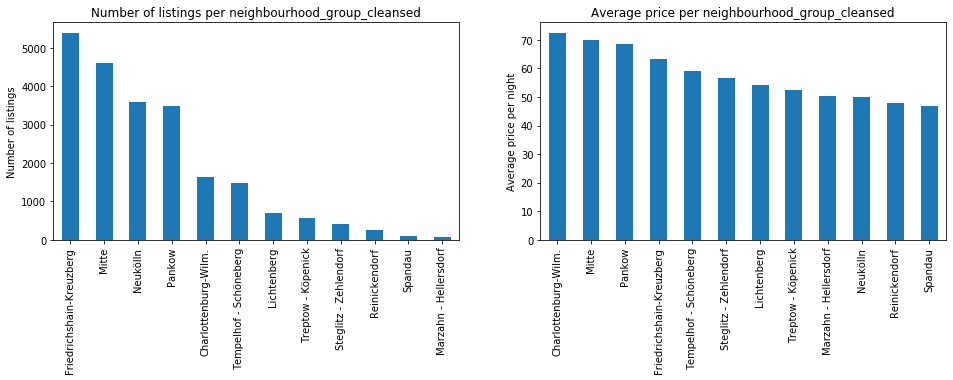

In [302]:
fig = plot_count_and_average_price_of_groups(apartments, 'neighbourhood_group_cleansed', 'price')
plt.show()

Next I want to know **whether there is some relationship between the number of listings and the average price per neighbourhooud**. Therefore I again one barchart for each metric but now **forcing the elements on the x-axis (the neighbourhoods) being in the same order**. Accordingly, each bar corresponds to one of the 139 neighbourhoods, and is in both plots at the same position.

What you can see is that there is obviously **no relationship between both metrics**. The average price of an apartment in a specific neighbourhood therefore does not seem to correlate with the number of competing listings.

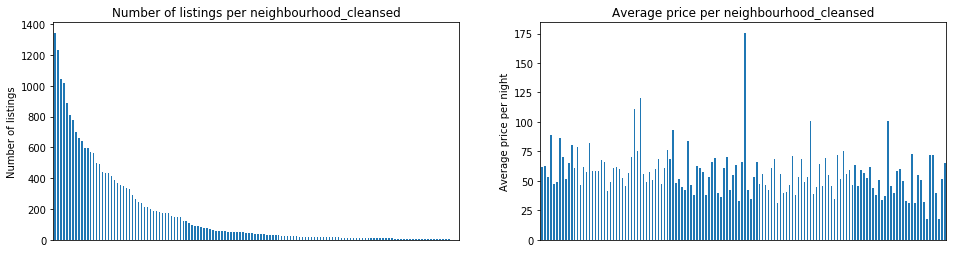

In [303]:
fig = plot_count_and_average_price_of_groups(apartments, 'neighbourhood_cleansed', 'price', sort_right='left')
ax_list = fig.axes
for ax in ax_list:
    ax.set_xticks([])
plt.show()

Now I want to use the geospatial information from the `neighbourhoods.geojson` file to **visualize** the prevalence and the average price of Airbnb apartments per neighbourhood **on a map**. Again, I provide to separate plots. On the left map you can see the number of listings per neighbourhood. The main - and not surprising - observation is that **most apartments** are located in **neighbourhoods near to the city center**. On the right map you find the average price per neighbourhood. It strengthes the observation from the previous plots indicating that there is no clear relationship between the number of listings and the average price per neighbourhood.

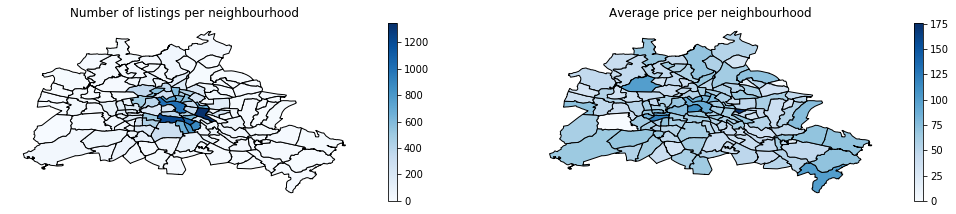

In [257]:
# Read geojson data and merge with number of apartments and average price per neighbourhood
neighbourhoods = gpd.read_file('./data/neighbourhoods.geojson')
neighbourhoods = neighbourhoods[~neighbourhoods['neighbourhood_group'].isnull()]
neighbourhood_stats = apartments.groupby('neighbourhood_cleansed', as_index=False).agg({'id': 'count', 'price': 'mean'})
neighbourhood_stats.columns = ['neighbourhood', 'count', 'price']
neighbourhoods = neighbourhoods.merge(neighbourhood_stats, 'left', 'neighbourhood')
neighbourhoods.fillna(0, inplace=True)
neighbourhoods.head()

# Create map
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
ax1.set_title('Number of listings per neighbourhood')
neighbourhoods.plot(ax=ax1, column='count', categorical=False, legend=True, cmap='Blues', edgecolor='black')
ax1.patch.set_visible(False)
ax1.axis('off')
ax2.set_title('Average price per neighbourhood')
neighbourhoods.plot(ax=ax2, column='price', categorical=False, legend=True, cmap='Blues', edgecolor='black')
ax2.patch.set_visible(False)
ax2.axis('off')
plt.tight_layout()
plt.show()

## Spaciousness

Next I will investigate the **influence of spaciousness on price**. There are four variables in the dataset that I relate to spaciousness: `room_type`, `accommodates`, `bedrooms` and `bathrooms`. Since they show in part a **high correlation to each other**, I will address only two of them in the following.

**Room type**

For Airbnb apartments there are three types of rooms: Entire homes, private rooms and shared rooms. The vast majority of listings belong to the first two groups, shared rooms are rather rare in the given dataset. From a price perspective a clear hierarchy can be seen. **For entire apartments** guests have to pay **on average almost double the price of private rooms**, and **private rooms are a bit more expensive than shared rooms**.

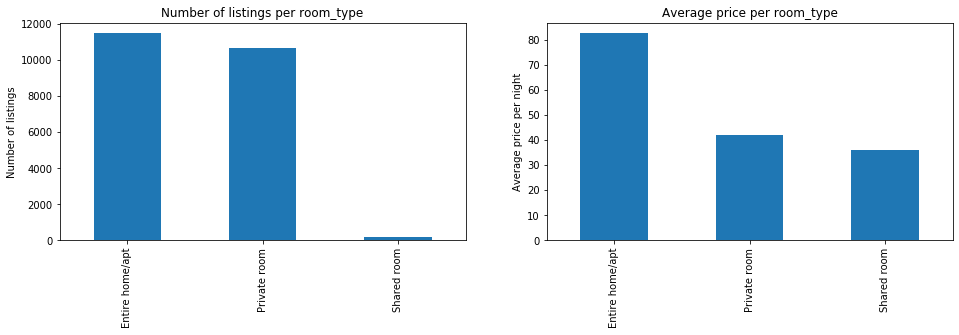

In [304]:
fig = plot_count_and_average_price_of_groups(apartments, 'room_type', 'price', sort_right='left')
plt.show()

**Guest capacity**

Regarding the remaining three spaciousness variables, I will first take a look on the variance of each variable and the correlation between them. There is **some variance in the `accommodates` variable** which gives us the maximal number of guests per listing, but only **small variance in the `bedrooms` and `bathrooms` variable**. Moreover, there is a moderate to strong correlation between all three variables. For this reason, I will **only examine the accommodates variable** in further detail assuming that it can serve as a **general proxy for the apartment size**.

In [323]:
print(np.round(apartments.accommodates.var(), 2))
print(np.round(apartments.bedrooms.var(), 2))
print(np.round(apartments.bathrooms.var(), 2))

2.26
0.41
0.09


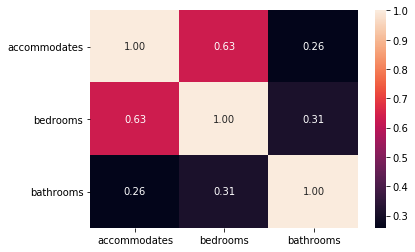

In [313]:
sns.heatmap(apartments[['accommodates', 'bedrooms', 'bathrooms']].corr(), annot=True, fmt='.2f')
plt.show()

**Most Airbnb apartments** in Berlin are intended for a **maximum of two people**. Apartments for more than five persons are rather rare. Regarding prices there is a clear - but not surprising - hierarchy. **The more people an apartment can potentially accommodate, the higher its price.**

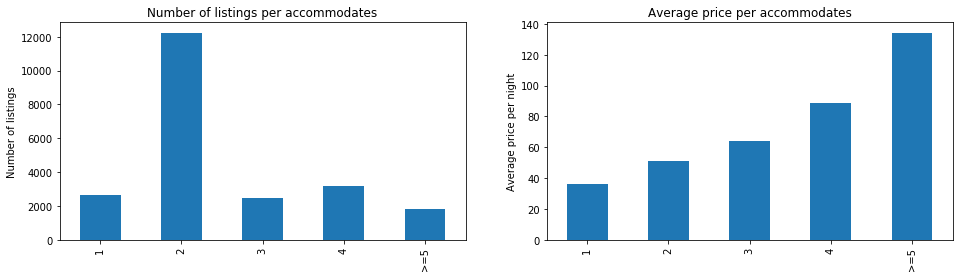

In [305]:
accommodates = apartments[['accommodates', 'price']].copy()
accommodates.loc[accommodates.accommodates>=5, 'accommodates'] = '>=5'
accommodates.accommodates = accommodates.accommodates.astype(str)
fig = plot_count_and_average_price_of_groups(accommodates, 'accommodates', 'price', sort_left='index', sort_right='index')
plt.show()

## Cleanliness

For the examination of the cleanliness of an apartment there is **no exogenous variable** we could make use of. Fortunately, there is the **guest rating** variable `review_scores_cleanliness`. Although, there are always biases in multidimensional user ratings, it will be still a good and **reasobale proxy for the real cleanliness** of a room.

What you can see in the left chart is that people indeed are **biased towards positive ratings**, so most ratings are 9 or 10. More exciting is the figure on the right which shows the average price of a listing per review score. As one would expect there is a **strong positive relationship between cleanliness** (as expressed in the user rating) **and price**.

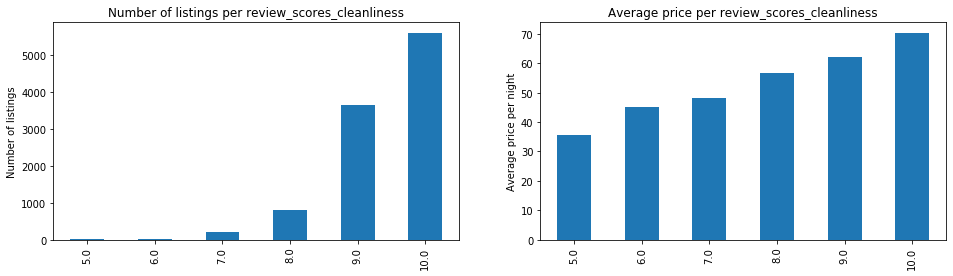

In [430]:
plot_count_and_average_price_of_groups(apartments[apartments.number_of_reviews>5], 'review_scores_cleanliness', 'price', sort_left='index', sort_right='index')
plt.show()

## Amenities

**Bed type**

There are five different bed types with **real bed** being by far the **most common** one. Because of the **low prevalence of all remaining categories** it is **hard to make consice statements** about prices.

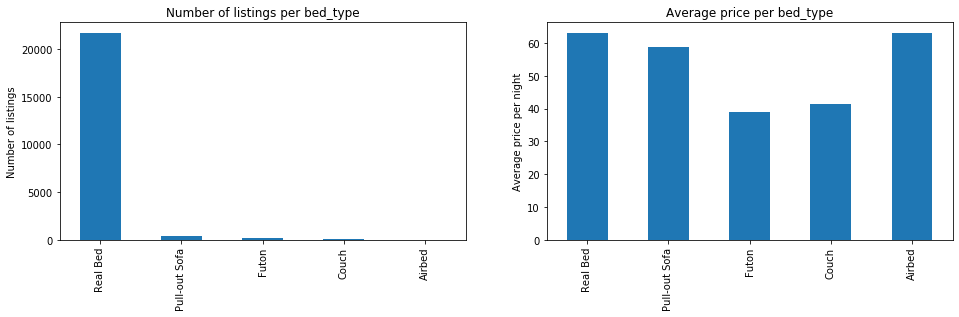

In [328]:
fig = plot_count_and_average_price_of_groups(apartments, 'bed_type', 'price', sort_right='left')
plt.show()

**Amenities**

Amenities are additional equipment and services that hosts can offer to their guests. In total, I find **171 different extra offers** in the present data set. However, there are no more than **four amenities that are present in at least 75% of all offers** (wifi, kitchen, heating, essentials). Then there is a **second group of amenities that is offered often** (in more than 10% of the listings) **but is not standard**, e.g. washer, hair dryer, refrigerator or dishwasher. **By far the largest group are amenities** that are only **provided by a rather small number of hosts** and therefore offer a high **potential for differentiation**, e.g. balcony or terrace.

In [331]:
apartments_amenities.shape

(22305, 171)

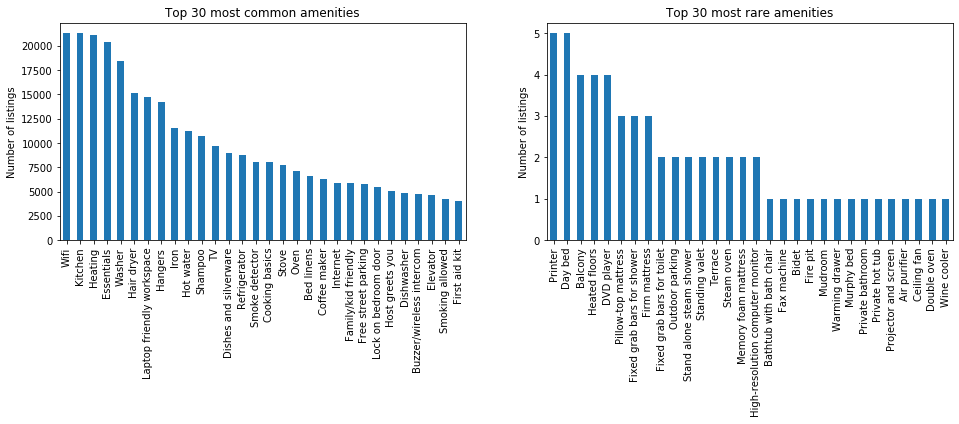

In [344]:
# Plot the 30 most common as well as the 30 most rare amenities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.set_title('Top 30 most common amenities')
ax1.set_ylabel('Number of listings')
apartments_amenities.sum(axis=0).sort_values(ascending=False).iloc[:30].plot(kind='bar', ax=ax1)
ax2.set_title('Top 30 most rare amenities')
ax2.set_ylabel('Number of listings')
apartments_amenities.sum(axis=0).sort_values(ascending=False).iloc[-30:].plot(kind='bar', ax=ax2)
plt.show()

Next I examine the average number of amenities hosts offer as well as its relationship to price. As can be seen in the histogram **most hosts provide between 5 and 15 different amenities**. There are **only a few apartments** comprising **less than 5** of such extra offers. But on the other hand, there is a **significant group of hosts** that offer **more than 15** different amenities.

Regarding the scatterplot on the right, there also seems to be some **positive relationship between the number of amenities of an apartment and its price**. It is important to notice here that it is rather difficult to make consice statements based on these types of scatterplots, but at least it can give us some indication for the relationship between two variables.

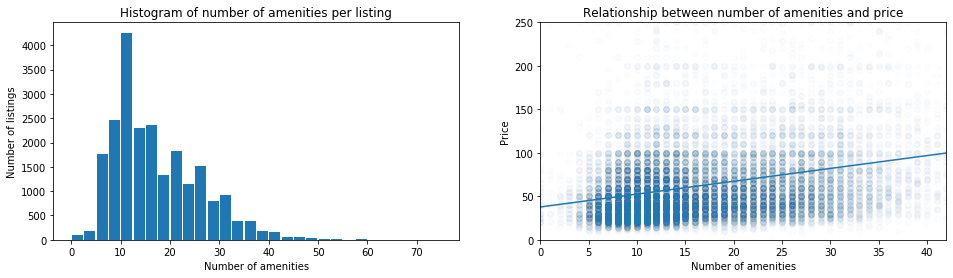

In [604]:
# Plot the distribution of the number of amenities per apartment and its relationship to price
apartments['number_of_amenities'] = apartments_amenities.sum(axis=1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.set_title('Histogram of number of amenities per listing')
ax1.set_ylabel('Number of listings')
ax1.set_xlabel('Number of amenities')
apartments.number_of_amenities.hist(rwidth=0.9, bins=30, ax=ax1)
ax1.grid(None)
ax2.set_title('Relationship between number of amenities and price')
ax2.set_ylabel('Price')
ax2.set_xlabel('Number of amenities')
ax2.scatter(apartments.number_of_amenities, apartments.price, alpha=0.01)

# Fit regression line to scatter plot
b, m = polyfit(apartments.number_of_amenities, apartments.price, 1)
xmin, xmax = 0, apartments.number_of_amenities.quantile(0.99)
ymin, ymax = 0, apartments.price.quantile(0.99)
plt.plot(np.linspace(xmin, xmax, 50), np.linspace(xmin, xmax, 50) * m + b)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymin, ymax])

plt.show()

## Reservation Terms

The reservation terms are **another potential value driver** of Airbnb listings. I assume that **guests love to be flexible** in both **making and canceling the booking**, and that hosts charge for this flexibility. To investigate this relationship I will next examine the variables `instant_bookable` and `cancellation_policy`.

**Instant booking**

For the first variable the picture is clear: **a third of the listings allow instant booking** and **hosts charge on average higher prices** for this flexibility.

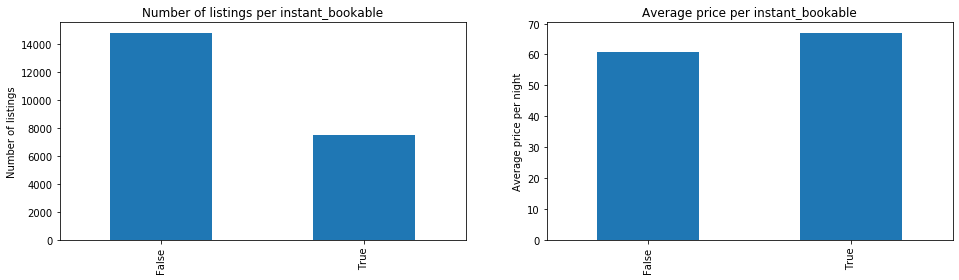

In [434]:
fig = plot_count_and_average_price_of_groups(apartments, 'instant_bookable', 'price', sort_left='index', sort_right='index')
plt.show()

**Cancellation policy**

Regarding cancellation policies, **the vast majority of hosts offer flexible or moderate cancellation terms**. However, as can be seen in the right chart, my **hypothesis about the relationship to price seems to be wrong**. My assumption was that the cancellation policy affects the value of a listing and thus its price. From this perspective flexible cancellation policies should correspond to higher prices. Interestingly, the right chart shows a relationship in the exact opposite direction: **the higher the price (and therefore the value of a listing), the stricter its cancellation policy**.

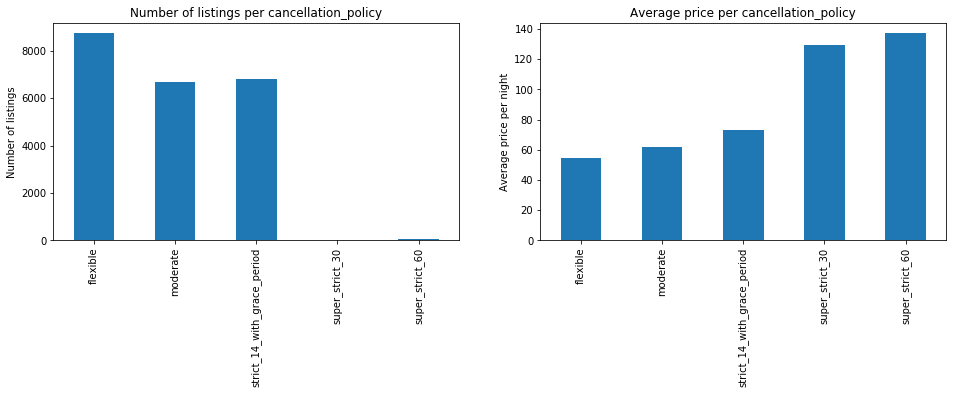

In [435]:
fig = plot_count_and_average_price_of_groups(apartments, 'cancellation_policy', 'price', sort_left='index', sort_right='index')
plt.show()

## Host

The host is the last value driver of Airbnb apartments I will examine in this analysis. There are three variables I will consider `host_is_superhost`, `host_response_time` and `review_scores_communication`.

**Superhost**

Airbnb defines superhosts as **"experienced hosts (...) who provide extraordinary experiences for their guests"**. There are tough requirements superhosts must meet so we can use this as a proxy for the overall quality of a host. Also in the given dataset the superhost status is rare: **only 10% of the listing in the given dataset are from superhosts**. At the same time corresponding listings are on average **associated with higher prices**, supporting the assumption that the superhost status adds value to a listing.

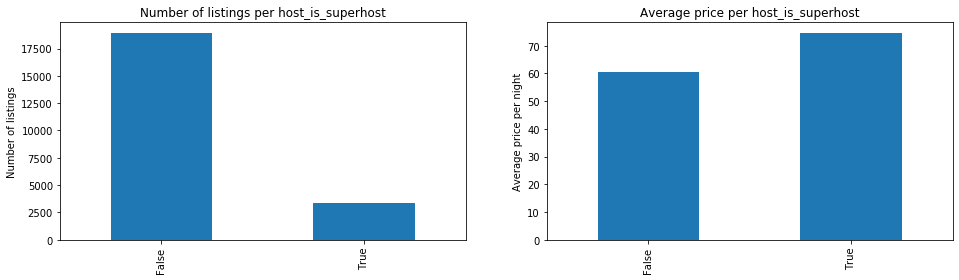

In [441]:
fig = plot_count_and_average_price_of_groups(apartments, 'host_is_superhost', 'price', sort_left='index', sort_right='index')
plt.show()

**Response time**

Regarding the average response time of a host, the picture is less clear. Although **hosts with an average response time under an hour charge on average higher prices**, it is rather **difficult to make consice statements about the relationship** between the two variables based on the given data.

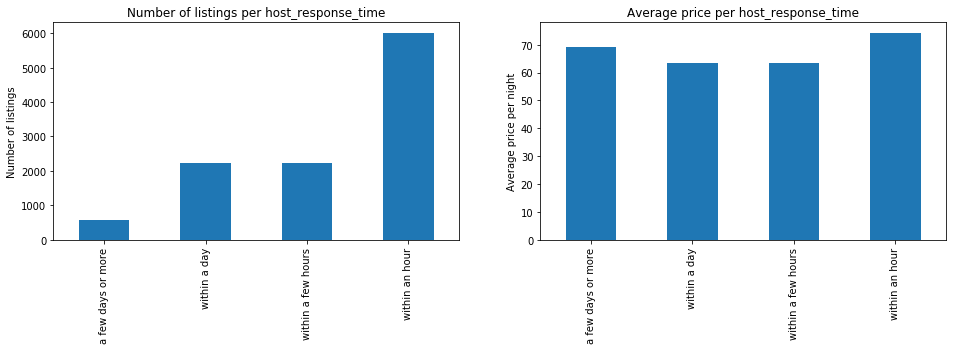

In [438]:
fig = plot_count_and_average_price_of_groups(apartments, 'host_response_time', 'price', sort_left='index', sort_right='index')
plt.show()

**Host communication**

Also for host communication the results are rather **ambigious**. Again we can see that users are biased towards positive ratings, but surprisingly there is **no clear relationship** between the ratings and price.

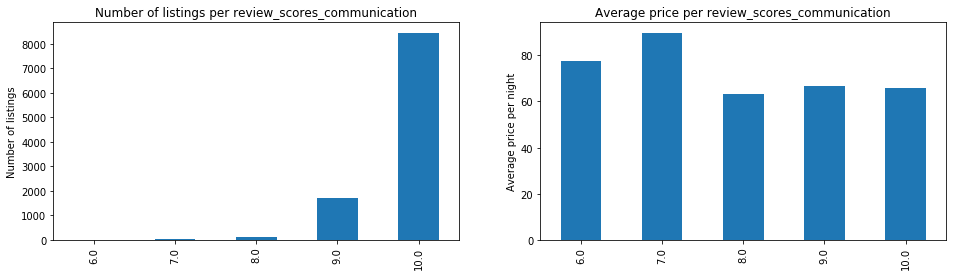

In [442]:
fig = plot_count_and_average_price_of_groups(apartments[apartments.number_of_reviews>5], 'review_scores_communication', 'price', sort_left='index', sort_right='index')
plt.show()

## Price

Next we will **completely focus on price**. The goal is to understand the **general price structure of Airbnb apartments in Berlin** but also to **identify specific pricing strategies**. Do hosts offer personal or quantity discounts? Do they charge cleaning fees or security deposits? For this purpose we will make use of the following variables: `price`, `guest_included`, `weekly_price`, `monthly_price`, `cleaning_fee` and `security deposit`.

**Price structure**

In the following I provide first a **high level view on the distribution of prices**, assigning each listing to a particular price bin. You can see that the **vast majority of listings** comes with **prices between 20€ and 100€**, with a high concentration in the lower 50. Only a comparatively small number of apartments are offered at price points greater than 100€.

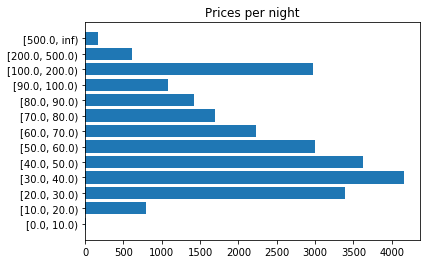

In [493]:
# General distribution of prices
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500, np.Inf]
price_structure = pd.cut(listings.price, bins=bins, right=False).value_counts().sort_index()
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title('Prices per night')
ax.barh(range(0, price_structure.shape[0]), price_structure, tick_label=price_structure.index)
plt.show()

Next I want to get a **more explicit view on the price distribution**. Instead of assigning each listing to a particular price bin, I make a histogram of the price points itself. For a better overview I only consider price points between 0€ and 200€ and split the distribution into two separate plots. Again **we can see a clear pattern**. The distribution shows that Airbnb hosts typically **round prices up or down to the nearest 5 price point**, with a stronger focus on 10 price points. The concentration on the **10 price point** becomes stronger **as the price level rises**.

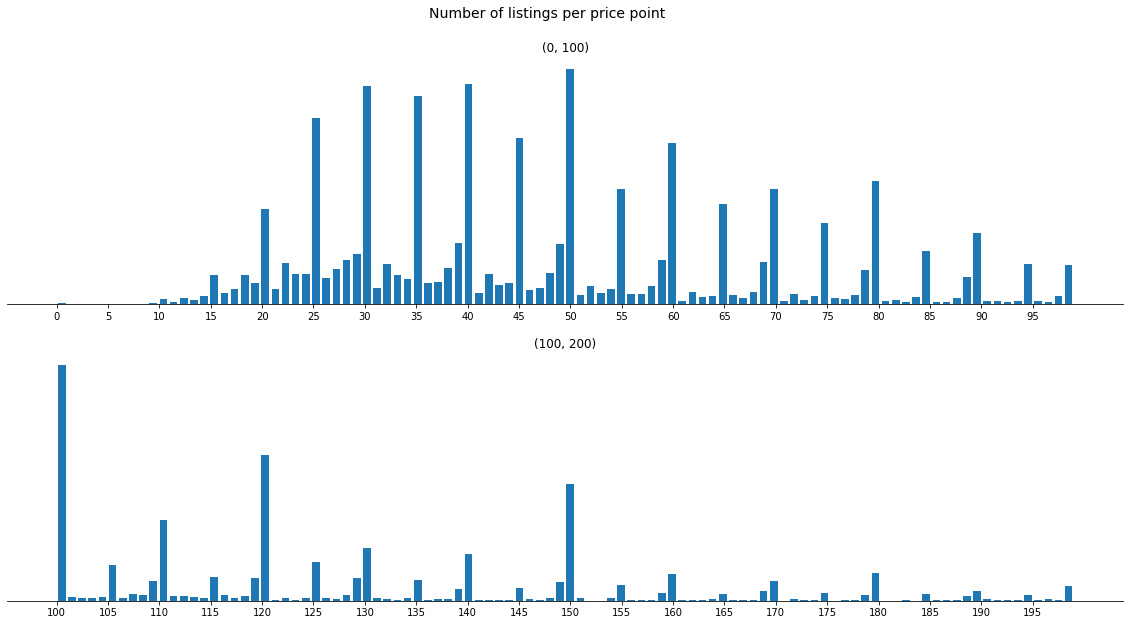

In [496]:
# Detailed distribution of prices
price_ranges = [(0, 100), (100, 200)]
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
fig.suptitle('Number of listings per price point', fontsize=14, y=0.95)
for i, price_range in enumerate(price_ranges):
    ax[i].set_title(price_range)
    listings.price[(listings.price>=price_range[0]) & (listings.price<price_range[1])].hist(bins=100, rwidth=0.75, ax=ax[i])
    ax[i].set_xticks(range(price_range[0], price_range[1], 5))
    ax[i].set_yticks([])
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].grid(None)

plt.show()

**Personal rebates**

Up to now, we have considered apartment prices **without taking into account the number of guests to which they apply**. However, it is obvious **this attribute will have a strong impact on the price itself**. In the following charts we can see that **most apartments** in Berlin **apply only to a single guest** anyway. However there is **also a significant number** of apartments with **prices set for two to four people**. Prices for a far higher number of guests also occur, but are rather rare.

On the right chart you can see the relationship of the variable to the overall price. Not surprisingly, **prices increase with the number of guests to which they apply**. 

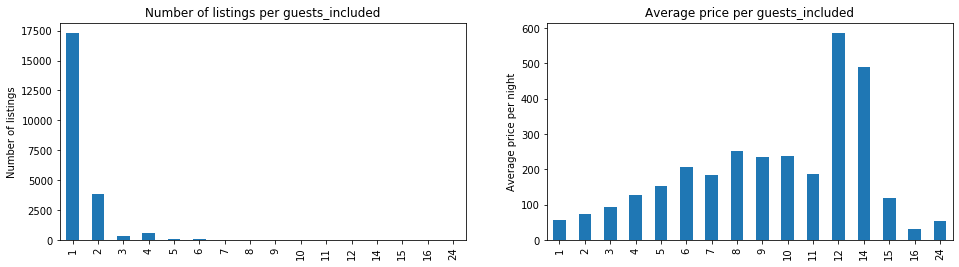

In [500]:
fig = plot_count_and_average_price_of_groups(apartments, 'guests_included', 'price', sort_left='index', sort_right='index')
plt.show()

The observation that prices increase with the number of guests to which they apply was obvious. More interesting is the question **whether the price per person decreases with the number of guests**, in other words whether hosts give personal rebates or not. For this purpose I **create a new variable `price_per_person`** giving the price per person and night and again create a barchart that gives the average of this variable for each level of the `guest_included` variable. 

What you can see is that **hosts indeed give personal rebates** but it is **rather unsensitive to the specific number of guests**. Accordingly, the biggest jump in the price per person can be seen between 1 and 2 guests.



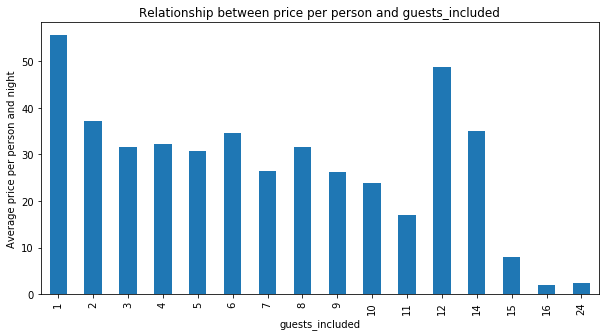

In [522]:
apartments['price_per_person'] = apartments.price/apartments.guests_included
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title('Relationship between price per person and guests_included')
apartments.groupby('guests_included').agg({'price_per_person': np.mean}).plot(kind='bar', ax=ax)
ax.get_legend().remove()
ax.set_ylabel('Average price per person and night')
plt.show()

**Quantity rebates**

Next I will **examine whether hosts give quantity discounts**. Airbnb provides the **possibility for hosts to set weekly and monthly prices** in addition to the regular pricing. I want to know to what extent these options differ from each other. For this purpose I generate a quotient from the weekly or monthly price and the projected regular price. This quotient then indicates **how much cheaper or more expensive** the respective week or month price is **relative to the regular price**.

Let us start with the week price. First of all, there is a **high missing value rate for the `weekly_price` variable**. I assume that this at least in part results from listings without special quantity prices. However, it is also conceivable that a technical problem is the reason for some the missing values. What you can see from the remaining listings is that **in most cases quantity discounts are given** (listings with ratios smaller than 1). The usual discounts are **moderate up to 25%**, only some hosts give strong discounts of up to 50% or even 75%.

In [553]:
apartments.weekly_price.isna().mean()

0.8775162519614437

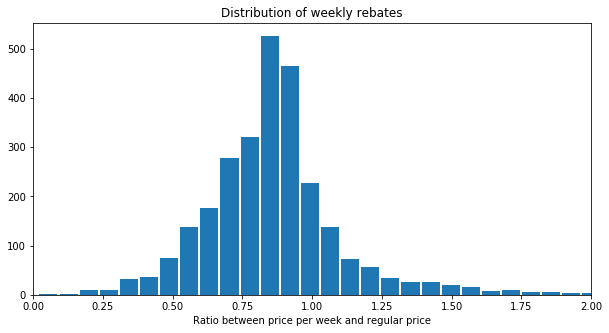

In [552]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title('Distribution of weekly rebates')
ax.set_xlabel('Ratio between price per week and regular price')
weekly_rebates = apartments.weekly_price/(apartments.price*7)
ax.hist(weekly_rebates, bins=100, rwidth=0.9)
ax.set_xlim([0,2])
plt.show()

Next I conduct the same analysis for the `monthly_price`. Once again, **a high proportion of missing values** can be observed. And also **for the remaining listings** the picture is **similar to the previous analysis**. Most hosts reduce the price for one month offers relative to the regular price. But **now even higher discounts of up to 60% are common**, which again indicates a **general trend towards volume discounts** on Airbnb apartments.

In [554]:
apartments.monthly_price.isna().mean()

0.9137413136068147

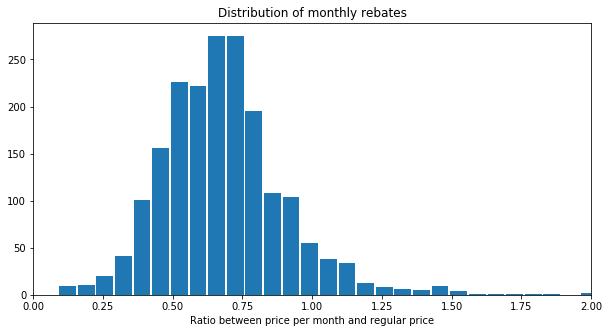

In [551]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title('Distribution of monthly rebates')
ax.set_xlabel('Ratio between price per month and regular price')
monthly_rebates = apartments.monthly_price/(apartments.price*28)
ax.hist(monthly_rebates, bins=70, rwidth=0.9)
ax.set_xlim([0,2])
plt.show()

**Extra costs**

The last part of the price analysis will deal with **extra costs that hosts can charge**. Therefore we will examine the variables `cleaning_fee` and `security_deposit`.

*Cleaning fee*

Let us start with the cleaning fee. Surprisingly, **cleaning fees are very common** in the given dataset. **87.7% of the listings without missing value charge a cleaning fee**, with this fee **tending to be between 10€ and 40€**. Surprisingly, there is **also a large percentage** of listings that **charge more than 50€ up to 200€** for cleaning.

In [578]:
apartments.cleaning_fee.isna().mean()

0.2990360905626541

In [576]:
(apartments.cleaning_fee>0).sum()/apartments.cleaning_fee.notna().sum()

0.8779661016949153

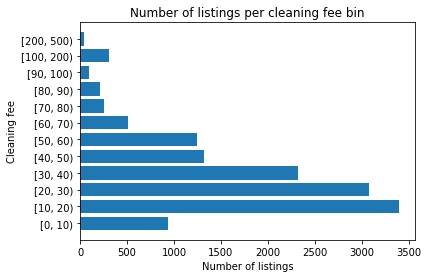

In [583]:
cleaning_fees = apartments.loc[apartments.cleaning_fee>0, 'cleaning_fee']
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500]
cleaning_fee_structure = pd.cut(cleaning_fees, bins=bins, right=False).value_counts().sort_index()
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title('Number of listings per cleaning fee bin')
ax.set_xlabel('Number of listings')
ax.set_ylabel('Cleaning fee')
ax.barh(range(0, cleaning_fee_structure.shape[0]), cleaning_fee_structure, tick_label=cleaning_fee_structure.index)
plt.show()

*Security deposit*

**Security deposits are also regularly requested** from the Airbnb hosts in the given dataset. Of the 61% of the listings for which a corresponding information available, **53.8% insist on a security deposit of at least 80€**. Most deposits **range between 100€ and 1000€**, but also larger deposit sums up to 2000€ and higher are possible.

In [585]:
apartments.security_deposit.isna().mean()

0.3904954046177987

In [586]:
(apartments.security_deposit>0).sum()/apartments.security_deposit.notna().sum()

0.5376976829716807

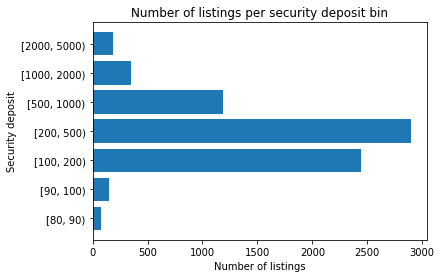

In [592]:
security_deposits = apartments.loc[apartments.security_deposit>0, 'security_deposit']
bins = [80, 90, 100, 200, 500, 1000, 2000, 5000]
security_deposit_structure = pd.cut(security_deposits, bins=bins, right=False).value_counts().sort_index()
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title('Number of listings per security deposit bin')
ax.set_xlabel('Number of listings')
ax.set_ylabel('Security deposit')
ax.barh(range(0, security_deposit_structure.shape[0]), security_deposit_structure, tick_label=security_deposit_structure.index)
plt.show()

# Data Modeling

In the previous section we have built up **a first intuition about the value drivers of Airbnb apartments and their relationship to price**. Next I want to exploit that knowledge for building a model that is able **predict the prices of Airbnb apartments** in Berlin. Therefore it is first necessary to think about a reasonable target variable and appropriate features that can explain this variable. For the **target variable** I will use the `price` column from the dataset, knowing that there are other price components (discounts, fees, etc.), as it makes the modeling much easier. For the initial **feature set** I will make a **selection based on the results from the previous section**, plus a handful of variables that we did not consider above, but which could still contribute to model performance.

**Feature selection**

In the following I prepare the feature set:

In [711]:
# Select initial features
df_features = apartments[['host_response_time', 'host_is_superhost', 'host_identity_verified', 'neighbourhood_cleansed', 
                       'room_type', 'accommodates', 'guests_included', 'review_scores_cleanliness', 
                       'review_scores_communication', 'review_scores_location', 'instant_bookable', 
                       'number_of_amenities']]

# Merge amenities
df_features = df_features.merge(apartments_amenities, left_index=True, right_index=True)

# Change boolean columns to integer
df_features.host_is_superhost = pd.to_numeric(df_features.host_is_superhost, errors='coerce')
df_features.host_identity_verified = pd.to_numeric(df_features.host_identity_verified, errors='coerce')
df_features.instant_bookable = pd.to_numeric(df_features.instant_bookable, errors='coerce')

# One hot encoding of categorical columns
df_features = pd.get_dummies(df_features, columns=['host_response_time', 'neighbourhood_cleansed', 'room_type'])

**Modeling**

Next I fit various linear models for different variance thresholds in feature selection:

In [733]:
def create_fit_test(X, y, threshold, test_size, random_state):
    ''' Creates, fits and tests a linear model for a given variance threshold
    for feature selection
    
    Input:
    X - np.array, feature matrix
    y - np.array, response vector
    threshold - float, variance threshold
    test_size - float, relative size of test group
    random_state - int, random seed
    
    Output:
    r2_train, r2_test, model
    '''
    
    # Split into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Imputation of missing values
    imputer = SimpleImputer(strategy='most_frequent')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    # Feature selection through variance thresholding
    selector = VarianceThreshold(threshold)
    X_train = selector.fit_transform(X_train)
    X_test = selector.transform(X_test)
    
    # Fit linear model
    lm = LinearRegression(normalize=True)
    lm.fit(X_train, y_train)
    r2_train = lm.score(X_train, y_train)
    
    # Predict on test set
    preds = lm.predict(X_test)
    r2_test = r2_score(y_test, preds)
    
    
    return r2_train, r2_test, lm
    
# Create feature matrix and response vector
X = df_features.values
y = apartments.price.values

# Set variance thresholds
thresholds = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.15]

# Create models
test_size = 0.1
random_state = 1
train_scores = []
test_scores = []
for threshold in thresholds:
    r2_train, r2_test, _ = create_fit_test(X, y, threshold, test_size, random_state)
    train_scores.append(r2_train)
    test_scores.append(r2_test)

**Evaluation**

A variance threshold of 0.02 produces the best model with a R2 score of 0.3672 on the test set:

In [735]:
results = pd.DataFrame({'threshold': thresholds, 'r2_train': train_scores, 'r2_test': test_scores})
results.head(10)

,threshold,r2_train,r2_test
0,0.0001,0.103831,0.321522
1,0.0005,0.095223,0.327449
2,0.0010,0.093538,0.331895
3,0.0050,0.089479,0.361248
4,0.0100,0.085583,0.365739
5,0.0200,0.083902,0.367223
6,0.0500,0.079832,0.351167
7,0.1000,0.079044,0.349099
8,0.1500,0.077164,0.342241
